In [1]:
import pandas as pd
import numpy as np
import torch 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import glob, os, pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import nn
from PIL import Image
from matplotlib import cm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

# Create Train/Test/Validation split 
- The patches that fall into the train, val, and test sets need to be from entirely distinct patient samples/WSI samples

In [4]:
#write a different data loader class 
class Patch_Class():
    def __init__(self, csv_path, root_dir, samples, transform=None):
        self.samples = samples # this will contain the WSI samples that we want to include in the dataset
        
        self.patch_frame = pd.read_csv(csv_path) #get the metadata 
        #adjust the metadata so that it only contains data from the samples we want
        self.patch_frame = self.patch_frame[self.patch_frame["ID"].isin(self.samples)]
        
        self.root_dir = root_dir
        self.transform = transform
        
        #we also need to build the patch dictionary, which maps sample_id to patch_id to status 
        self.patch_dict = {}
        self.build_dictionary()
        
        #here, we also need to load in all of the distinct np arrays for each directory
        self.data_dict = {}
        self.build_data()
        
    def build_data(self):
        #go through each sub dir in the main dir 
        for s_dir in tqdm(os.listdir(self.root_dir)):
            #again, only build data for the relevant samples
            if s_dir != "metadata.csv" and s_dir in self.samples:
                data = np.load(self.root_dir + s_dir +"/data.npy")
                self.data_dict[s_dir] = data #map the sample_id to the npy data 
                
    def build_dictionary(self):
        for sample in self.samples:
            #now, for each sample, make the dictionary
            self.patch_dict[sample] = {}
        for id, group in tqdm(self.patch_frame.groupby("ID")):
            #only build dic for the samples that are needed
            if id in self.samples:
                for idx, group2 in group.groupby("patch_index"):
                    self.patch_dict[id][idx] = (group2["scc"] == True)
            
    def __len__(self):
        return len(self.patch_frame)

    def __getitem__(self, index):        
        #1 is the file id
        sample_id = self.patch_frame.iloc[index, 1]
        patch_id = self.patch_frame.iloc[index, 8]
        #get the image as a numpy array 
        img = self.data_dict[sample_id][patch_id]
        
        #turn the array into a PIL image, so that it can be resized (this is done for the Efficient Net)
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        
        #get y_label and one hot encode it
#         ohe = [0, 0]
        y_label = int(list(self.patch_dict[sample_id][patch_id])[0])
#         ohe[y_label] = 1
        y_label = torch.tensor(y_label)

        if self.transform: 
            img = self.transform(img)
        return (img, y_label)

In [5]:
#transform the function according to the pytorch docs
from torchvision import transforms

img_size = 384
preprocess = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# the directories we need

path = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/data/metadata.csv"

root_dir = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/data/"


In [7]:
#get all of the sample names 
samples = []
for f in os.listdir(root_dir):
    if f != "metadata.csv":
        samples.append(f)

#split the sample names into train/test ~75/25
train, test = torch.utils.data.random_split(samples, [21, 9])

#further split train into train/validation
train, val = torch.utils.data.random_split(train, [18, 3])

In [8]:
# get all of the different kinds of patches 

train_patches = Patch_Class(path, root_dir, samples=set(train), transform = preprocess)
val_patches = Patch_Class(path, root_dir, samples=set(val), transform = preprocess)
test_patches = Patch_Class(path, root_dir, samples=set(test), transform = preprocess)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


In [9]:
print(test_patches.__getitem__(231))

print(len(test_patches))

(tensor([[[ 2.0263,  2.0263,  2.0263,  ...,  0.5022,  0.3823,  0.2796],
         [ 2.0263,  2.0263,  2.0263,  ...,  0.2453,  0.1426,  0.0569],
         [ 2.0263,  2.0263,  2.0263,  ..., -0.0972, -0.1657, -0.2342],
         ...,
         [ 2.0092,  2.0948,  2.0605,  ...,  1.3242,  1.1529,  1.0673],
         [ 1.9235,  2.0605,  2.1290,  ...,  1.1015,  1.0331,  1.0159],
         [ 1.8208,  2.0263,  2.1804,  ...,  0.9132,  0.9132,  0.9474]],

        [[ 2.2010,  2.2010,  2.2010,  ...,  0.0651, -0.0574, -0.1625],
         [ 2.2010,  2.2010,  2.2010,  ..., -0.2150, -0.3025, -0.3725],
         [ 2.2010,  2.2010,  2.2010,  ..., -0.5476, -0.6001, -0.6352],
         ...,
         [ 2.1835,  2.2710,  2.2360,  ...,  0.6078,  0.3978,  0.2927],
         [ 2.0959,  2.2360,  2.3060,  ...,  0.3627,  0.2752,  0.2402],
         [ 1.9909,  2.2010,  2.3585,  ...,  0.1702,  0.1527,  0.1702]],

        [[ 2.4134,  2.4134,  2.4134,  ...,  1.2805,  1.1585,  1.0539],
         [ 2.4134,  2.4134,  2.4134,  ...,  

In [10]:
print(len(val_patches), len(test_patches))

46128 135083


# Create the Dataloader
- also subset the datasets because they're big

In [26]:
#trim all datasets untill they are 1/10th of the size 

train_dataset, discard = torch.utils.data.random_split(train_patches, [int(len(train_patches)*.10), int(len(train_patches)*.9)])
print(len(train_dataset))

val_dataset, discard = torch.utils.data.random_split(val_patches, [int(len(val_patches)*.10), int(len(val_patches)*.9)+1])
print(len(val_dataset))

test_dataset, discard = torch.utils.data.random_split(test_patches, [int(len(test_patches)*.10), int(len(test_patches)*.9)+1])
print(len(test_dataset))

25730
4612
13508


In [27]:
batch_size = 64

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

# Load Model
- Also change the architecture slightly 

In [28]:
torch.hub.list("pytorch/vision")

Using cache found in /dartfs-hpc/rc/home/9/f003xr9/.cache/torch/hub/pytorch_vision_main


['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fcn_resnet101',
 'fcn_resnet50',
 'get_model_weights',
 'get_weight',
 'googlenet',
 'inception_v3',
 'lraspp_mobilenet_v3_large',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'raft_large',
 'raft_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf

In [41]:
model = torch.hub.load('pytorch/vision', 'efficientnet_v2_l', pretrained=True)

Using cache found in /dartfs-hpc/rc/home/9/f003xr9/.cache/torch/hub/pytorch_vision_main
/dartfs-hpc/rc/home/9/f003xr9/anaconda3/envs/jupyter_ultimate/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/dartfs-hpc/rc/home/9/f003xr9/anaconda3/envs/jupyter_ultimate/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
#visualize the layers 
ct = 0
for child in model.children():
    print("Layer: %d" %(ct))
    print(child)
    ct += 1

Layer: 0
Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stoc

In [43]:
# #we can also set the first, say, n layers to be frozen, and leave the remaining layers unfrozen, as follows 
# thresh = 1
# ct = 0
# #here we freeze up to and including the 6th layer
# for child in model.children():
#     if ct <= thresh:
#         for param in child.parameters():
#             param.requires_grad = False
#         print(child, ct)
#         ct += 1

In [44]:
#change the model architecture a bit (for vision transformer)
model.fc = nn.Sequential(nn.Linear(1000, 100), 
                         nn.ReLU(), 
                         nn.Dropout(p=.5), 
                         nn.Linear(100,2))
model

model.train()
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# Model Training 
- Still need to implement some standard data augmentation (i.e., rotation, flip, contrast, etc...)

In [45]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    model.eval() #put model in testing
    num_correct = 0
    num_samples = 0
    correct = {0:0, 1:0}
    total = {0:0, 1:0}
    with torch.no_grad():
        for x, y, name in tqdm(loader):
            #put batches on gpu 
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            for i,j in zip(predictions, y):
                if i.item() == j.item():
                    correct[i.item()] +=1
                total[j.item()] += 1
                num_correct += (predictions == y).sum()
                num_samples += predictions.size(0)

        print(
              f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
        acc = num_correct/num_samples
        #find the accuracies for each class 
        return acc, correct, total

    model.train()

In [46]:
#hyperparams
learning_rate = 1e-3
num_epochs =10 #20 works well - it seems as tho it is a local min 

Some notes
1. Might need to figure out another loss that works better with one hot encoding 
2. Also might need to figure out how to calc AUC-ROC 

In [49]:
# Loss and optimizer
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.


criterion = nn.CrossEntropyLoss()
# criterion = tgm.losses.FocalLoss(alpha=0.5, gamma=2.0, reduction='mean') #experimenting with focal loss 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=5, verbose=True)

#arrays to track the training loss and validation loss 
training_loss = []
validation_acc = []

# Train Network
for epoch in range(num_epochs):
    losses = []
    num_correct = 0
    num_samples = 0
    #train part 
    for batch_idx, (data, targets) in tqdm(enumerate(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        # print("Batch: %d. Loss: %f" %(batch_idx, loss))

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    mean_loss = sum(losses)/len(losses)
    training_loss.append(mean_loss)
    scheduler.step(mean_loss)

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")
    
    #model in test mode 
    model.eval()
    with torch.no_grad():
        acc = 0
        for x, y in tqdm(val_loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            #find the test loss
            loss = criterion(scores, y)


            #find the test accuracy 
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        #calc total acc here 
        acc = (num_correct/num_samples).item()
        print(acc)
        validation_acc.append(acc)
    #put the model back in train mode
    model.train()

0it [00:00, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 31.75 GiB total capacity; 30.22 GiB already allocated; 88.19 MiB free; 30.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Find/Calc/and Make AUC-ROC plot

In [36]:
from sklearn.metrics import roc_auc_score

softmax = nn.Softmax(dim=1)

In [37]:
model.eval()

probabilities = torch.Tensor([])
ground_truth = torch.Tensor([])

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device=device)
        y = y.to(device=device)
        #find the probs
        scores = softmax(model(x))
        
        #move to cpu
        scores = scores.to("cpu")
        y = y.to("cpu")
        
        #concat them 
        probabilities = torch.cat((probabilities, scores))
        ground_truth = torch.cat((ground_truth, y))
  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [02:37<00:00,  1.35it/s]


In [38]:
#predict the whole test cohort AUC-ROC

roc_auc_score(ground_truth, probabilities[:, 1])


0.8707074155324737

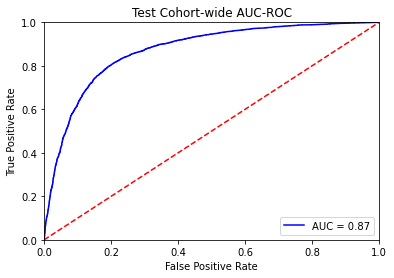

In [39]:
#from sophie's code - viz. the curve 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# fpr and tpr of all thresohlds
true = ground_truth
preds = probabilities[:, 1]
fpr, tpr, threshold = metrics.roc_curve(true, preds)

#get the metrics 
roc_auc = metrics.auc(fpr, tpr)

#plot
plt.title('Test Cohort-wide AUC-ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
!nvidia-smi

Sat Dec 17 14:34:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   39C    P0    55W / 300W |   7714MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [48]:
torch.cuda.empty_cache()